# **Skip-Gram vs BERT — Qual Modelo Classifica Melhor Reclamações de Clientes?**

*Desenvolvido como parte do MBA em Data Science & AI da FIAP, sob orientação do professor [Anderson Dourado](https://www.linkedin.com/in/anderson-dourado/).*<br><br>
⚡ Utilize GPU

## 1. **Introdução**



Neste projeto, enfrento um desafio clássico do NLP aplicado ao mercado: a categorização automática de reclamações de clientes.

Meu objetivo é encontrar o modelo que equilibre alto F1-Score e eficiência computacional. Para isso, testarei duas abordagens distintas:

1. **Embeddings estáticos (Skip-Gram + modelos clássicos de ML)**
2. **Transformers (BERT com fine-tuning)**

A grande pergunta que guia este experimento é:
Qual técnica se adapta melhor ao nosso problema e às particularidades dos dados disponíveis?

## 2. **Importação e Instalação de Bibliotecas**

In [1]:
!git clone https://github.com/luizh3nriqu3/data-science-projects.git

Cloning into 'data-science-projects'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9 (delta 0), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 9.93 MiB | 17.63 MiB/s, done.


In [2]:
!pip install torch --quiet
!pip install transformers sentence-transformers gensim xgboost scikit-learn spacy load_dotenv --quiet
!python -m spacy download pt_core_news_sm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠️ É necessário reiniciar o ambiente antes de rodar a importação das bibliotecas!

In [1]:
# Data Science
import numpy as np
import pandas as pd
import re
import string
import os
import zipfile
from pathlib import Path

# NLP
import nltk
import spacy
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, f1_score)
from sklearn.model_selection import train_test_split
import xgboost as xgb
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, BertModel
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch
from sklearn import preprocessing

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
# Cria diretório model, faz o download e unzip do skip-gram com 300 dimensões

model_dir = Path("data-science-projects/nlp/model")
model_dir.mkdir(parents=True, exist_ok=True)
zip_file = "skip_s300.zip"
file_path = model_dir / zip_file


if not file_path.exists():
    !wget 'https://dados-ml-pln.s3-sa-east-1.amazonaws.com/skip_s300.zip' -O {file_path}
else:
    print(f"Arquivo {zip_file} já existe.")

if file_path.exists():
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(model_dir)
    print(f"Arquivos extraídos.")
else:
    print(f"Erro: {zip_file} não encontrado.")

--2025-03-31 22:23:05--  https://dados-ml-pln.s3-sa-east-1.amazonaws.com/skip_s300.zip
Resolving dados-ml-pln.s3-sa-east-1.amazonaws.com (dados-ml-pln.s3-sa-east-1.amazonaws.com)... 3.5.234.164, 52.95.163.82, 16.12.0.2, ...
Connecting to dados-ml-pln.s3-sa-east-1.amazonaws.com (dados-ml-pln.s3-sa-east-1.amazonaws.com)|3.5.234.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 958619745 (914M) [application/zip]
Saving to: ‘data-science-projects/nlp/model/skip_s300.zip’

data-science-projec 100%[===================>] 914.21M  9.64MB/s    in 97s     

2025-03-31 22:24:43 (9.47 MB/s) - ‘data-science-projects/nlp/model/skip_s300.zip’ saved [958619745/958619745]

Arquivos extraídos.


## 3. **Importação da Base**

In [3]:
df = pd.read_csv('/content/data-science-projects/nlp/data/tickets_reclamacoes_classificados.csv', delimiter=';')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id_reclamacao         21072 non-null  int64 
 1   data_abertura         21072 non-null  object
 2   categoria             21072 non-null  object
 3   descricao_reclamacao  21072 non-null  object
dtypes: int64(1), object(3)
memory usage: 658.6+ KB


## 4. **EDA**

In [25]:
freq_cat = df['categoria'].value_counts()
freq_cat

,count
categoria,
Serviços de conta bancária,5161
Cartão de crédito / Cartão pré-pago,5006
Roubo / Relatório de disputa,4822
Hipotecas / Empréstimos,3850
Outros,2233


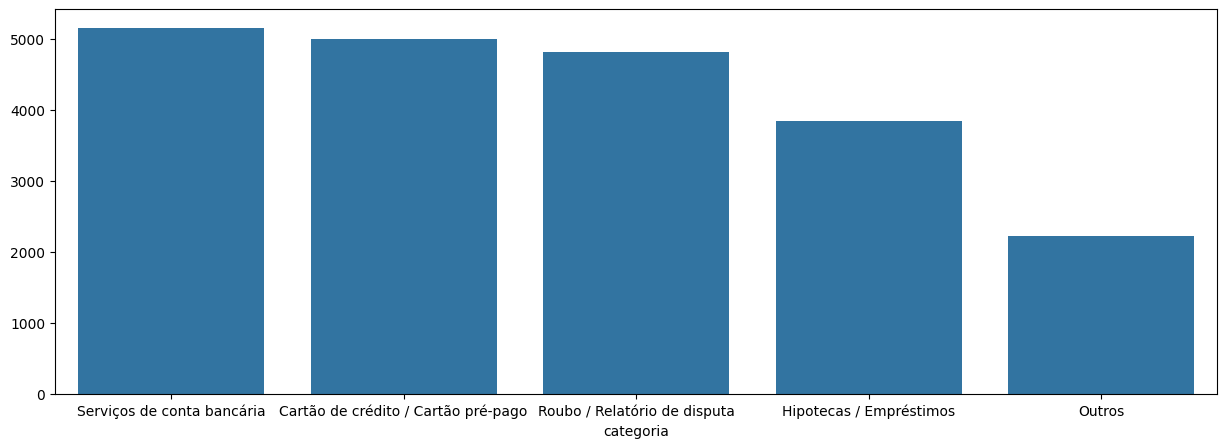

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x=freq_cat.index, y=freq_cat.values, ax=ax)
plt.show()

In [27]:
estatisticas = df[['num_palavras', 'num_caracteres']].describe().transpose()
estatisticas['moda'] = [df['num_palavras'].mode()[0], df['num_caracteres'].mode()[0]]
print(estatisticas)

                  count         mean          std  min    25%     50%  \
num_palavras    21072.0   247.782413   265.400668  2.0   95.0   177.0   
num_caracteres  21072.0  1465.305429  1585.890511  9.0  560.0  1041.0   

                    75%      max  moda  
num_palavras     312.25   5536.0    93  
num_caracteres  1843.25  33897.0   423  


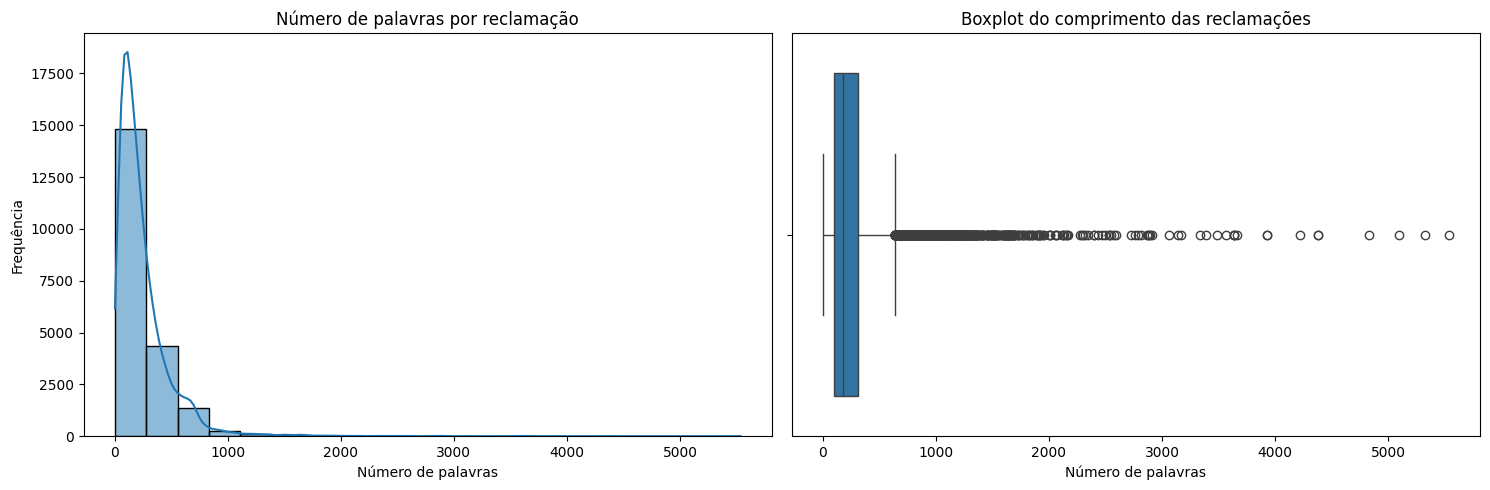

In [28]:
df['num_palavras'] = df['descricao_reclamacao'].apply(lambda x: len(str(x).split()))
df['num_caracteres'] = df['descricao_reclamacao'].apply(lambda x: len(str(x)))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['num_palavras'], bins=20, kde=True)
plt.title('Número de palavras por reclamação')
plt.xlabel('Número de palavras')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['num_palavras'])
plt.title('Boxplot do comprimento das reclamações')
plt.xlabel('Número de palavras')
plt.tight_layout()
plt.show()

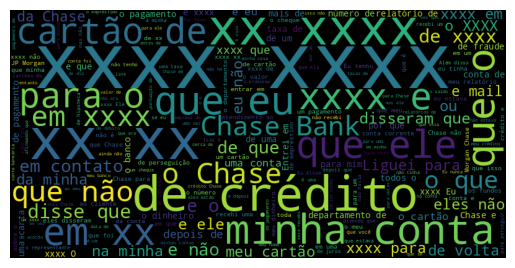

In [29]:
texto = ' '.join(df['descricao_reclamacao'].astype(str))
wordcloud = WordCloud(width=800, height=400).generate(texto)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [30]:
df[df['categoria'] == 'Serviços de conta bancária']['descricao_reclamacao'].iloc[0]

'Meu neto me dê cheque por {$ 1600,00} Eu depositei -o na minha conta Chase depois que o fundo limpo meu banco de perseguição fechou minha conta nunca me pagou meu dinheiro, eles disseram que precisavam para espreitar com o cheque do meu neto estava claro que o dinheiro estava fazendo pela minha perseguição Banco se recusa a me pagar meu dinheiro, meu neto chamou Chase 2 vezes, eles disseram que eu deveria ligar para ele para verificar o proprietário do cheque, ele está fora do país a maior parte da data de horário acontecer xx/xx/2018 Número de cheque xxxx Número de reclamação é xxxx com correr atrás'

In [31]:
df[df['categoria'] == 'Cartão de crédito / Cartão pré-pago']['descricao_reclamacao'].iloc[0]

'Atualizei meu cartão xxxx xxxx em xx/xx/2018 e fui informado pelo agente que fez a atualização que minha data de aniversário não mudaria. Ele virou o agente me dando as informações erradas para atualizar a conta. Xxxx alterou minha data de aniversário de xx/xx/xxxx para xx/xx/xxxx sem meu consentimento! XXXX tem a gravação do agente que me enganou.'

In [32]:
df[df['categoria'] == 'Roubo / Relatório de disputa']['descricao_reclamacao'].iloc[0]

'Em xxxx xx/xx/2019, fiz um pagamento {$ 300.00} a um varejista on -line usando o Chase Quick Pay com xxxx no site da Chase. Percebi que este era um site de fraudes após nenhuma confirmação, produto ou resposta a quaisquer perguntas sobre o pedido e contatou o Chase para obter mais informações sobre a transação para tentar obter um reembolso pelo banco de varejistas.\r\n\r\nEntrei em contato com o Chase por meio de uma mensagem segura em xx/xx/2019 explicando o que aconteceu e perguntei: "Existe uma maneira de reverter essa transação, ou você tem um contato no XXXX que pode me fornecer mais informações sobre o destinatário? \'\' Que xxxx , minha mensagem foi revisada e recebi uma resposta reafirmando meu e -mail original e me informando que "a transferência foi concluída. No entanto, como você mencionou que o site é uma farsa enquanto podemos lidar com a maioria das perguntas por e -mail, algumas exigem a experiência de outra equipe. Para ajudá -lo melhor em relação ao reembolso, solic

In [33]:
df[df['categoria'] == 'Hipotecas / Empréstimos']['descricao_reclamacao'].iloc[0]

'Bom dia, meu nome é xxxx xxxx e agradeço se você puder me ajudar a acabar com os serviços de membro do cartão bancário.\r\nEm 2018, escrevi para Chase solicitar verificação da dívida e o que eles me enviaram uma declaração que não é aceitável. Estou pedindo ao banco que valide a dívida. Em vez disso, recebi e -mails todos os meses, tentando coletar uma dívida.\r\nTenho o direito de conhecer essas informações como consumidor.\r\n\r\nConta do Chase # xxxx xxxx xxxx xxxx Obrigado antecipadamente pela sua ajuda.'

In [34]:
df[df['categoria'] == 'Outros']['descricao_reclamacao'].iloc[0]

'Durante os meses de verão, experimento uma renda de declínio devido ao meu emprego. Portanto, solicito uma extensão de pagamento de um mês com minha empresa de empréstimos para automóveis, Chase. Nos últimos quase quatro anos, meu pedido de extensão de pagamento é concedido. Nunca fui delinqüente com meu pagamento de empréstimo automático. No entanto, em XX/XX/2019, meu pedido de uma extensão de pagamento de um mês foi negada este ano. Expliquei minha situação ao representante e ao supervisor sem sucesso. Após uma longa discussão e espera, fui informado o motivo do declínio, pois não é "contratual". Esse motivo de negação me confundi e, portanto, enviei um e -mail ao Escritório da XXXX XXXX Diretor Executivo, Comunicação, JPMorgan Chase & Co. O representante entrou em contato comigo e afirmou que Chase seguirá. Cerca de semana depois, um representante do escritório xxxx xxxx xxxx chamado. O representante compartilhou seu papel foi ajudar a resolver o assunto. O representante via telec

Ao analisar nossos dados, destacam-se os seguintes aspectos:

**Balanceamento das Classes:**
As categorias apresentam um desbalanceamento moderado, sendo a classe mais frequente 2 vezes mais comum que a menos frequente. Ainda assim, o cenário não exige técnicas avançadas de balanceamento.

**Dados Sigilos:**
As descrições das reclamações contêm caracteres como 'x', utilizados para preservar a confidencialidade de informações sensíveis. Isso pode exigir um tratamento de pré-processamento específico.

**Formatação das Descrições:**
Algumas descrições incluem caracteres especiais, como \r e \n, que podem ser resquícios de formatação de texto. A remoção ou tratamento desses caracteres será necessária para evitar ruídos no processamento.

**Classe 'Outros':**
Essa classe provavelmente agrupa reclamações variadas, o que pode dificultar sua classificação precisa.

**Estatísticas de Tamanho:**<br>
Média: 247 palavras (1.465 caracteres)<br>
Mediana: 177 palavras (1.041 caracteres)


## 5. **Pré-processamento e Normalização**

### **Funcões de Pré-processamento, Normalização e Configurações**

In [35]:
# Define seed e tamanho de teste de conjunto de teste
seed = 42
test_size = 0.25

In [36]:
# Define se o código vai rodar na GPU (se disponível) ou na CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Rodando em: {device}")

# Carrega a lista de stopwords em português
stopwords_list = nltk.corpus.stopwords.words('portuguese')

# Lista de nomes de instituições encontradas na EDA
institution_names = ['chase', 'bank', 'jp', 'gm', 'financial', 'jpmcb']

# Cria uma cópia do dataframe com apenas as colunas relevantes
df_model = df[['categoria', 'descricao_reclamacao']].copy()

# Divide o dataset em treino e teste
df_train, df_test = train_test_split(df_model, test_size=test_size, random_state=seed)

# Converte as categorias em valores numéricos
label_encoder = preprocessing.LabelEncoder()
df_train['categoria'] = label_encoder.fit_transform(df_train['categoria'])
df_test['categoria'] = label_encoder.transform(df_test['categoria'])

Rodando em: cuda


In [37]:
# Remove pontuação de um texto
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Normaliza o texto
def normalize_text(text, replace_institutions=False):
    text = text.lower()
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'\d+|/', '', text)
    text = re.sub(r'\bx\b|\w*xx+\w*', '', text)
    text = remove_punctuation(text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    if replace_institutions:
        for institution in institution_names:
            text = re.sub(r'\b' + re.escape(institution) + r'\b', '[INST]', text)
    else:
        for institution in institution_names:
            text = re.sub(r'\b' + re.escape(institution) + r'\b', '', text)

    return text

# Normaliza e tokeniza o texto
def norm_tokenize(text):
    text = normalize_text(text, replace_institutions=False)
    tokens = word_tokenize(text)
    text = [x for x in tokens if x not in stopwords_list]
    return [y for y in text if len(y) > 2]

# Lematiza os tokens usando spacy
def lemmatize_tokens(tokens, pos="VERB"):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ if token.pos_ == pos else token.text for token in doc]

# Normaliza e tokeniza o texto usando o tokenizer do BERT
def bert_tokenize(text):
    text = normalize_text(text, replace_institutions=True)
    words = re.findall(r'\[INST\]|\w+|\S', text)
    filtered_words = [word for word in words if word not in stopwords_list]

    # Tokeniza o texto com BERT
    tokens = tokenizer(
        " ".join(filtered_words),
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

    return tokens

### **Pré-processamento e Normalização para Skip-gram**:
  1. **Limpeza Básica:**
* Conversão para minúsculas
* Remoção de \r, \n, dígitos, caracteres sigilosos e pontuação.
* Normalização de espaços (duplos → simples, trim de espaços extras).
  2. **Tratamento Específico:**
* Remoção de stopwords e tokens de marcas/instituições (ex: chase, bank).
* Tokenização com word_tokenize (NLTK).
* Lematização de verbos (para reduzir variações).

In [38]:
# Carrega o modelo de NLP do spacy para português
nlp = spacy.load("pt_core_news_sm")

# Se estiver rodando na GPU roda o spacy com GPU
if device.type == "cuda":
    spacy.require_gpu()

In [39]:
# Aplica a tokenização e remove stopwords
df_train['tokens'] = df_train['descricao_reclamacao'].apply(norm_tokenize)
df_test['tokens'] = df_test['descricao_reclamacao'].apply(norm_tokenize)

# Lematiza os tokens de verbos
df_train['tokens'] = df_train['tokens'].apply(lambda tokens: lemmatize_tokens(tokens, pos="VERB"))
df_test['tokens'] = df_test['tokens'].apply(lambda tokens: lemmatize_tokens(tokens, pos="VERB"))

### **Pré-processamento e *Normalização* para BERT**
  1. **Limpeza similar ao Skip-gram, mas com adaptações:**
* Substituição de marcas/instituições por [INST].
* Tokenização com o tokenizador do BERT.
* Remoção de stopwords.

2. **Preparação dos Tensores:**
 * Remoção da dimensão extra dos tokens gerados pelo BERT.
 * Conversão dos dados em tensores, contendo: (input_ids, attention_mask e categorias)
 * Separação dos tensores em conjuntos de treino e teste para avaliação.


**Observação:**
Apesar de práticas como descapitalização (modelo cased), remoção de pontuação e stopwords não serem recomendadas para BERT, meus testes mostraram +2% de acurácia com essas transformações. Possíveis razões:
* O modelo utilizado não é dos mais recentes (ex: BERT vs RoBERTa).
* O conjunto de dados pode conter ruídos que as limpezas ajudaram a mitigar.

In [41]:
# Inicializa o tokenizer do BERT treinado para português
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Adiciona um token personalizado ao vocabulário do tokenizer, caso ainda não exista
if "[INST]" not in tokenizer.get_vocab():
    tokenizer.add_tokens(["[INST]"])

In [42]:
# Tokeniza o texto usando o modelo BERT
df_train['tokens_bert'] = df_train['descricao_reclamacao'].apply(bert_tokenize)
df_test['tokens_bert'] = df_test['descricao_reclamacao'].apply(bert_tokenize)

In [43]:
# Extrai os tensores de input_ids, attention_mask e token_type_ids dos tokens BERT
df_train['input_ids'] = df_train['tokens_bert'].apply(lambda x: x['input_ids'].squeeze(0))
df_train['attention_mask'] = df_train['tokens_bert'].apply(lambda x: x['attention_mask'].squeeze(0))
df_train['token_type_ids'] = df_train['tokens_bert'].apply(lambda x: x['token_type_ids'].squeeze(0))

df_test['input_ids'] = df_test['tokens_bert'].apply(lambda x: x['input_ids'].squeeze(0))
df_test['attention_mask'] = df_test['tokens_bert'].apply(lambda x: x['attention_mask'].squeeze(0))
df_test['token_type_ids'] = df_test['tokens_bert'].apply(lambda x: x['token_type_ids'].squeeze(0))

# Converte os dados processados em TensorDatasets para treino e teste
train_tensor = TensorDataset(
    torch.stack(df_train['input_ids'].tolist()),
    torch.stack(df_train['attention_mask'].tolist()),
    torch.tensor(df_train['categoria'].tolist())
)

test_tensor = TensorDataset(
    torch.stack(df_test['input_ids'].tolist()),
    torch.stack(df_test['attention_mask'].tolist()),
    torch.tensor(df_test['categoria'].tolist())
)

## 6. **Embedding**

Nesta etapa, focaremos no Skip-gram, já que o BertForSequenceClassification processa os embeddings internamente, incluindo sua própria camada de classificação.

### **Embedding com Skip-gram**

* Utilizei o Word2Vec (Skip-gram) para representar cada palavra como um vetor de 300 dimensões.
* Para textos com múltiplos tokens, apliquei a média dos vetores (vetores médios).

In [44]:
# Carrega os vetores Word2Vec pré-treinados com 300 dimensões
model_skip = KeyedVectors.load_word2vec_format('/content/data-science-projects/nlp/model/skip_s300.txt')

In [45]:
# Calcula o vetor médio de uma lista de tokens usando o modelo Word2Vec
def average_vector(words):
    vectors = [model_skip[word] for word in words if word in model_skip]

    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return np.zeros(model_skip.vector_size)

In [46]:
# Converte os tokens em vetores médios usando Word2Vec para treino e teste
X_train = df_train['tokens'].apply(average_vector).tolist()
X_test = df_test['tokens'].apply(average_vector).tolist()

# Cria y de treino e teste
y_test = df_test['categoria']
y_train = df_train['categoria']

## 7. **Pipeline de Treino e Teste**

### **Fine-Tuning do BERT**

**Hiperparâmetros Utilizados:**

- Épocas: Até 10
- Batch Size: 32
- Learning Rate: 5e-5

**Técnicas para Melhorar o Treinamento:**
- Otimizador AdamW com a técnica "weight decay" para prevenir o overfitting .
- Scheduler de taxa de aprendizagem com warmup para aumentar a taxas de aprendizagem gradualmente e evitar grandes ajustes nos pesos no início.
- Early stopping para evitar overfitting e interromper o o treinamento se a loss não melhorar por 2 épocas, e salvar o  modelo com menor test loss.
- Após o treinamento de cada época o modelo é avaliado e as métricas exibidas em tela.

In [47]:
# Obtém o número de classes únicas no conjunto de treinamento
num_classes = len(df_train['categoria'].unique())

# Configurações de treinamento
batch_size = 32
learning_rate = 5e-5
num_epochs = 10

# Carrega o modelo BERT com dropout personalizado
model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased',
    num_labels=len(label_encoder.classes_),
    classifier_dropout=0.2,
    hidden_dropout_prob=0.2
)

# Atualiza tamanho do vocabulário para incluir [INST]
model.resize_token_embeddings(len(tokenizer))

# Define o otimizador com weight decay
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Prepara o scheduler de taxa de aprendizado com warmup
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Configura o Early Stopping
best_test_loss = float('inf')
patience = 2
trigger_times = 0

# Move o modelo para GPU se disponível
model.to(device)

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Zera os gradientes antes da retropropagação
        optimizer.zero_grad()

        # Passagem para frente no modelo
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

    # Cálculo das métricas de treino
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples

    # Validação
    model.eval()
    total_test_loss = 0.0
    correct_test_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_test_loss += loss.item()
            _, preds = torch.max(outputs.logits, dim=1)
            correct_test_predictions += torch.sum(preds == labels).item()

    # Métricas de validação
    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = correct_test_predictions / len(test_tensor)

    print(f"\nEpoch {epoch + 1}:")
    print(f"  Training Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy:.4f}")
    print(f"  Test Loss:     {avg_test_loss:.4f} | Accuracy: {test_accuracy:.4f}")

    # Verificação de early stopping
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"\nEarly stopping at epoch {epoch + 1}!")
            break

# Carrega o melhor modelo após o treinamento
model.load_state_dict(torch.load('best_model.pt'))

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


Epoch 1: 100%|██████████| 494/494 [05:21<00:00,  1.53it/s]



Epoch 1:
  Training Loss: 0.7708 | Accuracy: 0.6979
  Test Loss:     0.3988 | Accuracy: 0.8500


Epoch 2: 100%|██████████| 494/494 [05:18<00:00,  1.55it/s]



Epoch 2:
  Training Loss: 0.3498 | Accuracy: 0.8744
  Test Loss:     0.3406 | Accuracy: 0.8776


Epoch 3: 100%|██████████| 494/494 [05:18<00:00,  1.55it/s]



Epoch 3:
  Training Loss: 0.2572 | Accuracy: 0.9088
  Test Loss:     0.3584 | Accuracy: 0.8774


Epoch 4: 100%|██████████| 494/494 [05:17<00:00,  1.55it/s]



Epoch 4:
  Training Loss: 0.1805 | Accuracy: 0.9379
  Test Loss:     0.3787 | Accuracy: 0.8743

Early stopping at epoch 4!


<All keys matched successfully>

In [48]:
# Coloca o modelo em modo de avaliação
model.eval()

# Listas para armazenar as previsões e as labels verdadeiras
all_predictions = []
all_labels = []

# Desabilita o cálculo de gradientes para economizar memória e acelerar o processo
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Inverte a transformação das labels
predicted_labels = label_encoder.inverse_transform(all_predictions)
true_labels = label_encoder.inverse_transform(all_labels)

# Exibe o relatório de classificação
print()
print(classification_report(true_labels, predicted_labels))

# Calcula e imprime o F1 Score ponderado
print("F1 Score:", f1_score(true_labels, predicted_labels, average="weighted"))


Evaluating: 100%|██████████| 165/165 [00:34<00:00,  4.75it/s]


                                     precision    recall  f1-score   support

Cartão de crédito / Cartão pré-pago       0.88      0.91      0.89      1290
            Hipotecas / Empréstimos       0.93      0.86      0.89       922
                             Outros       0.81      0.89      0.85       549
       Roubo / Relatório de disputa       0.89      0.82      0.85      1204
         Serviços de conta bancária       0.87      0.91      0.89      1303

                           accuracy                           0.88      5268
                          macro avg       0.87      0.88      0.87      5268
                       weighted avg       0.88      0.88      0.88      5268

F1 Score: 0.8774628494198892


**Análise das Métricas**:
O BERT alcançou um F1 Score bastante alto (87%) e estaria apto para rodar em produção.

**Observações importantes:**
* A partir da época 3, o modelo apresenta sinais de overfitting, mesmo com AdamW e learning rate com warmup.
* O early stopping endereça esse problema, salvando o melhor modelo.
* O tamanho do dataset atual pode estar limitando o potencial do BERT.

Embora o BERT tenha apresentado um bom desempenho, os sinais de overfitting indicam que o modelo poderia se beneficiar de um conjunto de dados maior – seja através da coleta de novas amostras ou de técnicas de aumento artificial de dados.

### **Testando o Skip-gram**

Para avaliar a qualidade dos embeddings gerados pelo Skip-gram, comparei quatro modelos de classificação com diferentes abordagens:

- Regressão Logística
- Random Forest
- XGBoost
- SVM

A escolha desses modelos busca testar diferentes abordagens, incluindo modelos simples (Regressão Logística), ensemble (Random Forest e XGBoost) e métodos baseados em kernels (SVM), com o objetivo de encontrar o melhor desempenho utilizando o mínimo de recursos computacionais.

In [49]:
# Lista de pipelines contendo os modelos a serem treinados e avaliados
pipelines = [
    ('Logistic Regression', X_train, y_train, X_test, y_test, LogisticRegression(random_state=seed)),
    ('Random Forest', X_train, y_train, X_test, y_test, RandomForestClassifier(random_state=seed)),
    ('XGBoost', X_train, y_train, X_test, y_test, xgb.XGBClassifier(random_state=seed)),
    ('SVC Linear', X_train, y_train, X_test, y_test, SVC(kernel='linear', random_state=seed)),
    ('SVC RBF', X_train, y_train, X_test, y_test, SVC(kernel='rbf', random_state=seed)),

]

# Itera sobre cada modelo no pipeline, treinando e avaliando
for name, X_train, y_train, X_test, y_test, model_skip in pipelines:
    model_skip.fit(X_train, y_train)
    y_pred = model_skip.predict(X_test)
    print(f'Classification Report de {name}:\n{classification_report(y_test, y_pred)}\n')
    print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
    print("-"*80)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report de Logistic Regression:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1290
           1       0.84      0.88      0.86       922
           2       0.84      0.75      0.79       549
           3       0.81      0.79      0.80      1204
           4       0.84      0.89      0.87      1303

    accuracy                           0.84      5268
   macro avg       0.84      0.83      0.84      5268
weighted avg       0.84      0.84      0.84      5268


F1 Score: 0.8416829922536863
--------------------------------------------------------------------------------
Classification Report de Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1290
           1       0.75      0.77      0.76       922
           2       0.80      0.50      0.61       549
           3       0.67      0.71      0.69      1204
           4       0.77      0.81      0.79

### **Modelo Vencedor: SKIP-GRAM + SVC** 🏆

Embora o BERT tenha apresentado um F1-score um pouco superior (87% x 85%), o Skip-gram + SVC foi eleito vencedor por ter um melhor custo-benefício.

**Motivos da Escolha:**

1. **Eficiência Computacional:**
 * Skip-Gram é de 50 até 100 vezes mais rápido no treino e de 10 até 50 vezes mais rápido na inferência.
 * O BERT emite até 50 vezes mais CO2.
 * Modelos Skip-Gram ocupam de 5 até 10 vezes menos espaço.
 * O BERT precisa GPU para treinamento.
 * O BERT consome 10 vezes mais RAM durante o treino e de 15 até 30 vezes mais em inferência.

2. **Performance Próxima:**
 * Diferença de apenas 2 pontos percentuais no F1, compensada pela economia de custos.
 * O SVC ainda pode ter seu desempenho aprimorado com ajuste de hiperparâmetros (ex: kernel, regularização).

### 8. **Pipeline Completa do Modelo Vencedor**

#### **Importação de Bibliotecas**

In [1]:
!git clone https://github.com/luizh3nriqu3/data-science-projects.git

Cloning into 'data-science-projects'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9 (delta 0), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 9.93 MiB | 5.22 MiB/s, done.


In [2]:
!pip install gensim spacy --quiet
!python -m spacy download pt_core_news_sm --quiet
!pip install torch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 21.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

⚠️ É necessário reiniciar o ambiente antes de rodar a importação das bibliotecas!

In [20]:
# Data Science
import numpy as np
import pandas as pd
import re
import string
import joblib
from pathlib import Path
import zipfile
from sklearn.pipeline import Pipeline


# NLP
import nltk
import spacy
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize

# Machine Learning
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, f1_score)
from sklearn.model_selection import train_test_split
import torch
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score

# NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

In [6]:
# Cria diretório model, faz o download e unzip do skip-gram com 300 dimensões

model_dir = Path("data-science-projects/nlp/model")
model_dir.mkdir(parents=True, exist_ok=True)
zip_file = "skip_s300.zip"
file_path = model_dir / zip_file


if not file_path.exists():
    !wget 'https://dados-ml-pln.s3-sa-east-1.amazonaws.com/skip_s300.zip' -O {file_path}
else:
    print(f"Arquivo {zip_file} já existe.")

if file_path.exists():
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(model_dir)
    print(f"Arquivos extraídos.")
else:
    print(f"Erro: {zip_file} não encontrado.")

Arquivo skip_s300.zip já existe.
Arquivos extraídos.


#### **Importação da Base**

In [7]:
df = pd.read_csv('/content/data-science-projects/nlp/data/tickets_reclamacoes_classificados.csv', delimiter=';')

#### **Pré-processamento e Normalização**

In [8]:
# Define seed e tamanho de conjunto de teste
seed = 42
test_size = 0.25

In [9]:
# Define se o código vai rodar na GPU (se disponível) ou na CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Rodando em: {device}")

# Carrega a lista de stopwords em português
stopwords_list = nltk.corpus.stopwords.words('portuguese')

# Lista de nomes de instituições encontradas na EDA
institution_names = ['chase', 'bank', 'jp', 'gm', 'financial', 'jpmcb']

# Cria uma cópia do dataframe com apenas as colunas relevantes
df_model = df[['categoria', 'descricao_reclamacao']].copy()

# Divide o dataset em treino e teste
df_train, df_test = train_test_split(df_model, test_size=test_size, random_state=seed)

# Converte as categorias em valores numéricos
label_encoder = preprocessing.LabelEncoder()
df_train['categoria'] = label_encoder.fit_transform(df_train['categoria'])
df_test['categoria'] = label_encoder.transform(df_test['categoria'])

Rodando em: cpu


In [10]:
# Remove pontuação de um texto
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Normaliza o texto
def normalize_text(text, replace_institutions=False):
    text = text.lower()
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'\d+|/', '', text)
    text = re.sub(r'\bx\b|\w*xx+\w*', '', text)
    text = remove_punctuation(text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    for institution in institution_names:
            text = re.sub(r'\b' + re.escape(institution) + r'\b', '', text)

    return text

# Normaliza e tokeniza o texto
def norm_tokenize(text):
    text = normalize_text(text, replace_institutions=False)
    tokens = word_tokenize(text)
    text = [x for x in tokens if x not in stopwords_list]
    return [y for y in text if len(y) > 2]

# Lematiza os tokens usando spacy
def lemmatize_tokens(tokens, pos="VERB"):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ if token.pos_ == pos else token.text for token in doc]

In [11]:
# Carrega o modelo de NLP do spacy para português
nlp = spacy.load("pt_core_news_sm")

# Se estiver rodando na GPU roda o spacy com GPU
if device.type == "cuda":
    spacy.require_gpu()

In [12]:
# Aplica a tokenização e remove stopwords
df_train['tokens'] = df_train['descricao_reclamacao'].apply(norm_tokenize)
df_test['tokens'] = df_test['descricao_reclamacao'].apply(norm_tokenize)

# Lematiza os tokens de verbos
df_train['tokens'] = df_train['tokens'].apply(lambda tokens: lemmatize_tokens(tokens, pos="VERB"))
df_test['tokens'] = df_test['tokens'].apply(lambda tokens: lemmatize_tokens(tokens, pos="VERB"))

#### **Embedding**

In [14]:
# Carrega os vetores Word2Vec pré-treinados com 300 dimensões
model_skip = KeyedVectors.load_word2vec_format('/content/data-science-projects/nlp/model/skip_s300.txt')

In [15]:
# Calcula o vetor médio de uma lista de tokens usando o modelo Word2Vec
def average_vector(words):
    vectors = [model_skip[word] for word in words if word in model_skip]

    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return np.zeros(model_skip.vector_size)

In [16]:
# Converte os tokens em vetores médios usando Word2Vec para treino e teste
X_train = df_train['tokens'].apply(average_vector).tolist()
X_test = df_test['tokens'].apply(average_vector).tolist()

# Cria y de treino e teste
y_test = df_test['categoria']
y_train = df_train['categoria']

#### **Treinamento e Teste**

Apesar da busca por parâmetros do SVC ainda demandar recursos computacionais significativos, ela é consideravelmente mais eficiente em comparação ao fine-tuning do BERT.

In [22]:
pipeline = Pipeline([
    ('svc', SVC(random_state=seed))])

param_grid = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__C': [0.1, 1],
    'svc__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
print('\nMelhores parâmetros encontrados:')
print(grid_search.best_params_)
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))


Fitting 3 folds for each of 8 candidates, totalling 24 fits

Melhores parâmetros encontrados:
{'svc__C': 1, 'svc__class_weight': None, 'svc__kernel': 'rbf'}

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1290
           1       0.85      0.87      0.86       922
           2       0.85      0.78      0.81       549
           3       0.83      0.81      0.82      1204
           4       0.87      0.89      0.88      1303

    accuracy                           0.85      5268
   macro avg       0.85      0.84      0.85      5268
weighted avg       0.85      0.85      0.85      5268

F1 Score: 0.8519338635982009


#### **Salvando .pkl do melhor modelo**

In [23]:
# Salva o .pkl do modelo campeão
model_dir = Path("/content/data-science-projects/nlp/best-model")
model_path = model_dir / "modelo_skipgram_svc.pkl"

model_dir.mkdir(parents=True, exist_ok=True)

try:
    joblib.dump(best_model, model_path)
    print("Modelo salvo!")
except Exception as e:
    print("Erro ao salvar o modelo.")

Modelo salvo!
